In [46]:
# generate Chlorophyll for nwa25 grid from seawifs climatology
# made wiht xgcm tools - had to install hct flood and also numba (from numba channel)
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf
from HCtFlood import kara as flood

In [47]:
# grab seawifs data from Udel thredds, subset to our domain, resample to make monthly climatology. Note that resampling will require some decent computation time.

#wifs = xr.open_dataset("http://basin.ceoe.udel.edu/thredds/dodsC/SEAWIFSDAILY9KM.nc").sel(lat=slice(0,70), lon=slice(-100,-30))
#wifs = wifs['chlor_a']
#wifs_mon = wifs.groupby('time.month').mean('time')
#wifs_mon.to_netcdf("seawifs-clim.1997-2010.nc", format='NETCDF3_64BIT')

In [189]:
# we ran the code above on another machine and saved the file. Open this file up
wifs = xr.open_dataset("seawifs-clim.1997-2010.nc")

In [190]:
# create seawifs file by creating xarray dataset from scratch and adding extra dimensions we need
lon_list = np.append(wifs['lon'].values, (wifs['lon'].values[-1] - (wifs['lon'].values[-2] - wifs['lon'].values[-1])))
lat_list = np.append(wifs['lat'].values,wifs['lat'].values[-1] - (wifs['lat'].values[-2] - wifs['lat'].values[-1]))
# create dataset
seawifs = xr.Dataset({
    'CHL_A': xr.DataArray(
                data   = wifs['chlor_a'].values,   # enter data here
                dims   = ['time', 'j', 'i'],
                coords = {'time': wifs.month.values,
                          'i' : np.arange(0.5,len(wifs.lon.values)+0.5,1),
                          'j' : np.arange(0.5,len(wifs.lat.values)+0.5,1)}),
        
    'lon_crnr': xr.DataArray(
                data   = lon_list,   # enter data here
                dims   = ['IQ'],
                coords = {'IQ' : np.arange(0,len(wifs.lon.values)+1,1)}),
    
    'lat_crnr': xr.DataArray(
                data   = lat_list,   # enter data here
                dims   = ['JQ'],
                coords = {'JQ' : np.arange(0,len(wifs.lat.values)+1,1)})   
    })

# assign other coordinates
seawifs = seawifs.assign_coords(lon=("i", wifs.lon.values))
seawifs = seawifs.assign_coords(lat=("j", wifs.lat.values))

In [50]:
hgrid = xr.open_dataset("/Users/james/Documents/Github/nwa25/setup/grid/ocean_hgrid.nc")

In [51]:
mom_grid = {
    'lon': hgrid.x[1::2, 1::2],
    'lon_b': hgrid.x[::2, ::2],
    'lat': hgrid.y[1::2, 1::2],
    'lat_b': hgrid.y[::2, ::2]
}

# From Alistair
mom_area = (hgrid.area[::2, ::2] + hgrid.area[1::2, 1::2]) + (hgrid.area[1::2, ::2] + hgrid.area[::2, 1::2])

In [52]:
flooded = flood.flood_kara(seawifs['CHL_A'], xdim='i', ydim='j').drop('z').squeeze()
flooded

<xarray.DataArray 'CHL_A' (time: 12, j: 840, i: 840)>
dask.array<getitem, shape=(12, 840, 840), dtype=float32, chunksize=(1, 840, 840), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) float64 0.5 1.5 2.5 3.5 4.5 ... 835.5 836.5 837.5 838.5 839.5
  * i        (i) float64 0.5 1.5 2.5 3.5 4.5 ... 835.5 836.5 837.5 838.5 839.5

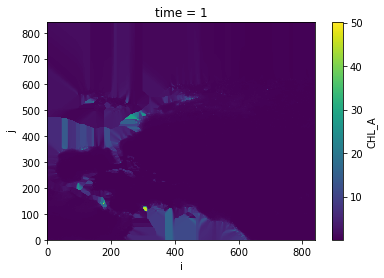

In [53]:
flooded.isel(time=0).plot()

In [54]:
seawifs_grid = {
    'lon': seawifs.lon,
    'lat': seawifs.lat,
    'lon_b': seawifs.lon_crnr,
    'lat_b': seawifs.lat_crnr
}

In [55]:
seawifs_to_mom = xesmf.Regridder(seawifs_grid, mom_grid, method='conservative', reuse_weights=False)

Overwrite existing file: conservative_840x840_1690x1550.nc 
 You can set reuse_weights=True to save computing time.


In [56]:
regridded = seawifs_to_mom(flooded)

/Users/james/opt/anaconda3/envs/xgcmTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


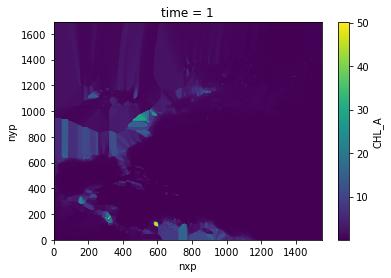

In [57]:
regridded.isel(time=0).plot()

In [107]:
ds = regridded.to_dataset().transpose('time', 'nyp', 'nxp').rename({'nxp': 'xh', 'nyp': 'yh'})

In [108]:
ds['area'] = (('yh', 'xh'), mom_area.values)

In [109]:
ds['lon_crnr'] = (('yq', 'xq'), mom_grid['lon_b'].values)
ds['lat_crnr'] = (('yq', 'xq'), mom_grid['lat_b'].values)

In [110]:
ds['xh'] = (('xh'), np.arange(len(ds['xh']), dtype=np.int32))
ds['yh'] = (('yh'), np.arange(len(ds['yh']), dtype=np.int32))
ds['xh'].attrs['cartesian_axis'] = 'X'
ds['yh'].attrs['cartesian_axis'] = 'Y'

In [112]:
ds = ds.assign_coords(time=("time", np.array([cftime.DatetimeNoLeap(1, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 5, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 6, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 7, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 8, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 9, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 12, 16, 12, 0, 0, 0)])))

In [186]:
ds = ds.assign_coords(time=("time", xr.cftime_range(start=cftime.DatetimeNoLeap(1, 1, 15, 12, 0, 0, 0),end=cftime.DatetimeNoLeap(1, 12, 31, 23, 0, 0, 0), freq="732H")))
ds.time.attrs['modulo'] = ' '
ds.time.attrs['long_name'] = 'Time'
ds.time.attrs['cartesian_axis'] = 'T'


In [140]:
all_vars = list(ds.data_vars.keys()) + list(ds.coords.keys())
encodings = {v: {'_FillValue': None} for v in all_vars}
encodings['time'].update({'dtype':'float64'})

In [188]:
ds['lon'] = ds['lon'].astype(dtype='float32')
ds['lat'] = ds['lat'].astype(dtype='float32')
ds['area'] = ds['area'].astype(dtype='float32')
ds['lon_crnr'] = ds['lon_crnr'].astype(dtype='float32')
ds['lat_crnr'] = ds['lat_crnr'].astype(dtype='float32')

In [143]:
ds.to_netcdf('seawifs-clim.1997.2010.nwa25.nc', 
    encoding=encodings, 
    format='NETCDF3_64BIT',
    unlimited_dims='time'
)